In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow_examples.models.pix2pix import pix2pix

In [3]:
from xrayproject import segmentation_zero
from xrayproject.utils import load_train, load_masks
from xrayproject.preprocessing import normalize, flip_resize, resize_test

## We want to create a bunch of functions that integrate Kim's baseline classification-model with David's segmentation-model. How do we want to do this?

### First, to do anything, we need to import raw images. Our full model will be designed to run on only these raw images...

In [13]:
path_image = '../raw_data/raw_PRC/CXR_png/'
path_mask = '../raw_data/raw_PRC/CXR_mask/'

masks, targets, ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

Using path:  ../raw_data/raw_PRC/CXR_mask/
Using bucket 
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0608_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0333_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0469_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0433_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0386_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0662_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0388_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0610_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0451_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0625_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0591_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0423_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0479_1_mas

In [14]:
images, IDs = load_train(ID, path = path_image)

Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0022_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0433_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0610_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0594_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0124_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0225_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0508_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0058_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0380_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0104_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0384_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0630_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0469_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0469_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0139_0

### However, we need to have well-trained segmentation-model. So, to begin with, we're going to load a huge number of image-mask pairs, and train the segmentation model to ensure that we have anything useful.

In [15]:
resized = [flip_resize(images[i], masks[i], input_shape=(224, 224)) for i in range(len(images))]

In [16]:
seg_model = segmentation_zero.Segmentation_UNET()

In [17]:
seg_model.base_model()

In [18]:
seg_model.unet_model()

In [19]:
seg_model.initialize_model()

Initializing model...


In [40]:
seg_model.train(images, masks, targets, epochs=50)

Preprocessing...
Initializing model...
Starting train..
Epoch 1/50
5/5 [==============================] - 18s 3s/step - loss: 0.8404 - accuracy: 0.6228 - val_loss: 0.6835 - val_accuracy: 0.6354
Epoch 2/50
5/5 [==============================] - 12s 2s/step - loss: 0.5623 - accuracy: 0.7015 - val_loss: 0.4892 - val_accuracy: 0.7661
Epoch 3/50
5/5 [==============================] - 15s 3s/step - loss: 0.4278 - accuracy: 0.8045 - val_loss: 0.3568 - val_accuracy: 0.8764
Epoch 4/50
5/5 [==============================] - 13s 3s/step - loss: 0.3459 - accuracy: 0.8295 - val_loss: 0.2526 - val_accuracy: 0.9222
Epoch 5/50
5/5 [==============================] - 14s 3s/step - loss: 0.2927 - accuracy: 0.8438 - val_loss: 0.1945 - val_accuracy: 0.9519
Epoch 6/50
5/5 [==============================] - 12s 3s/step - loss: 0.2525 - accuracy: 0.8730 - val_loss: 0.1655 - val_accuracy: 0.9587
Epoch 7/50
5/5 [==============================] - 13s 3s/step - loss: 0.2238 - accuracy: 0.9039 - val_loss: 0.1488 -

### Now that the segmentation-model is trained, we then need to design functions that map the outputs of the segmentation-model into a format that the classification-model can properly analyze. We do this here.

#### To start, we define a function that maps the output-predictions of the UNET-model back into images:

In [41]:
def unet_to_mask_img(raw_lung_xray):
    img_funct = seg_model.model.predict(raw_lung_xray[tf.newaxis, ...]).squeeze()
    img_funct = np.sign(img_funct)
    img_funct = (1+np.resize(img_funct, (224, 224, 1)))/2
    return img_funct

In [42]:
print(resized[0][0].shape,
      resized[0][1].shape,
      resized[0][2].shape,
      resized[0][3].shape)

(224, 224, 3) (224, 224, 1) (224, 224, 3) (224, 224, 1)


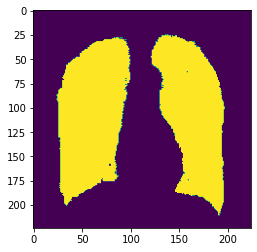

In [43]:
plt.imshow(unet_to_mask_img(resized[5][0]))
plt.show()

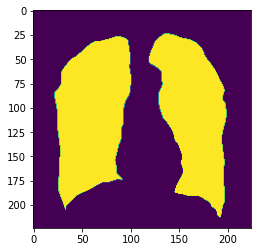

In [44]:
plt.imshow(resized[5][1])
plt.show()

#### It's helpful to have totally new images and masks, to gain confidence that the model actually predicts masks reasonably well:

In [47]:
new_masks, new_targets, new_ID = load_masks(100, get_all = False, get_random = True, balanced = True, path = path_mask)

Using path:  ../raw_data/raw_PRC/CXR_mask/
Using bucket 
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0367_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0478_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0610_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0628_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0513_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0512_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0331_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0452_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0616_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0438_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0327_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0366_1_mask.png
Loading local file:  ../raw_data/raw_PRC/CXR_mask/CHNCXR_0595_1_mas

In [48]:
new_images, new_IDs = load_train(new_ID, path = path_image)

Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0452_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0452_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0366_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0513_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0004_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0554_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0610_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0594_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0569_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0225_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0145_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0279_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0535_1.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0061_0.png
Loading local file:  ../raw_data/raw_PRC/CXR_png/CHNCXR_0061_0

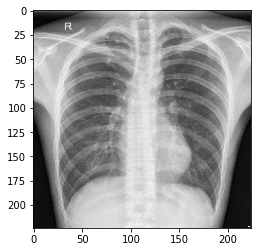

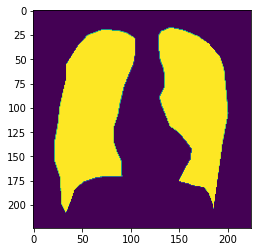

In [49]:
new_xray_imgs = [tf.image.resize(new_images[i]/255, (224, 224)) for i in range(len(new_images))]
new_xray_masks = [tf.image.resize(new_masks[i]/255, (224, 224)) for i in range(len(new_images))]

plt.imshow(new_xray_imgs[0])
plt.show()

plt.imshow(new_xray_masks[0])
plt.show()

#### Now, with these new images/masks, we print-out the outputs and compare them:

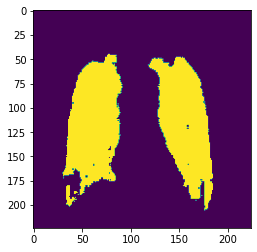

In [54]:
plt.imshow(unet_to_mask_img(new_xray_imgs[5]))
plt.show()

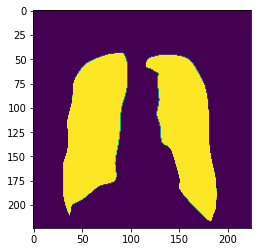

In [52]:
plt.imshow(new_xray_masks[5])
plt.show()

#### Now that we see that the model works OK on these new lungs, we need to output a set of model-generated masks for the downstream pathology-prediction model. We do this here:

In [57]:
!ls

Untitled_DAM.ipynb                  seg_test.ipynb
loading_xrays.ipynb                 segmentation_attempt_DAM.ipynb
loading_xrays_DAM.ipynb             segmentation_attempt_DAM_nice.ipynb
model                               segmentation_attempt_DAM_v1.ipynb
pipeline_groundwork_DAM.ipynb       segmentation_attempt_DAM_v2.ipynb
seg_pred_stitch_DAM.ipynb           segmentation_attempt_DAM_v3.ipynb


In [58]:
loaded_model = tf.keras.models.load_model('model')

In [67]:
def unet_to_mask_img(raw_lung_xray,mask_model=seg_model):
    if mask_model == seg_model:        
        img_funct = mask_model.model.predict(raw_lung_xray[tf.newaxis, ...]).squeeze()
        img_funct = np.sign(img_funct)
        img_funct = (1+np.resize(img_funct, (224, 224, 1)))/2
    else:
        img_funct = tf.image.resize(raw_lung_xray, (128, 128))
        img_funct = mask_model.predict(img_funct[tf.newaxis, ...]).squeeze()
        img_funct = np.sign(img_funct)
        img_funct = (1+np.resize(img_funct, (128, 128, 1)))/2
    return img_funct

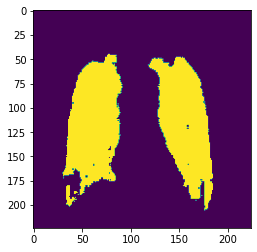

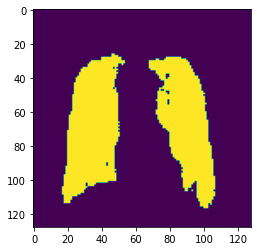

In [68]:
plt.imshow(unet_to_mask_img(new_xray_imgs[5]))
plt.show()

plt.imshow(unet_to_mask_img(new_xray_imgs[5],mask_model=loaded_model))
plt.show()

### Finally, we feed these modified outputs of the segmentation-model into the classifier model, and see how well it does.